In [140]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit


In [141]:
# Import custom classes
from supervised_model_pipeline import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [142]:
# Load the training data
indi_file_path = '../../Data/Clean/combined/Indianapolis_combined.csv'
train_full_df = pd.read_csv(indi_file_path)
train_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,149771.0,2151.0,291536100.0,131097.969553,133638.666266,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,956.7,0.2,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
1,2008-05-31,151827.0,2430.0,331352084.0,132148.045670,133520.379815,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,958.9,0.5,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
2,2008-06-30,154789.0,2438.0,362561539.0,132930.782306,133559.343193,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,958.2,0.3,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
3,2008-07-31,157222.0,2457.0,383886935.0,133222.597102,133449.285413,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,961.2,1.5,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"
4,2008-08-31,154119.0,2309.0,370365976.0,133037.483397,133164.069995,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,959.9,0.3,1488.97601,90.664284,36.279526,"INDIANAPOLIS, IN"


In [143]:
# Remove columns that are too predictive
cols_to_remove = ['HomeValueIndexSmSa', 'HomeValueIndex']
train_full_df = train_full_df.drop(cols_to_remove, axis=1)

## Create an EdaToolbox object

In [144]:
# Initialize the EdaToolbox
target_col = 'MeanSalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

In [145]:
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"INDIANAPOLIS, IN",1,0,0.0,"Index(['INDIANAPOLIS, IN'], dtype='object', na..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,1488.97601,1,0,0.0,"Index([1488.97601], dtype='float64', name='Peo..."
PctHighSchoolDiploma_2019,float64,1.000000,90.664284,1,0,0.0,"Index([90.664284], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,36.279526,1,0,0.0,"Index([36.279526], dtype='float64', name='PctB..."


In [146]:
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## First check the distribution of the target column and select an appropriate target column transformer

In [147]:
# It is not normally distributed. It has a long tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}

In [148]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(np.logspace(-6, 6, 25)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}


In [149]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [150]:
# Use basic ordinal feature transformer
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

In [151]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.164092,0.162498,1.000185,0.691195,0.235408,0.278630,0.161404,0.083179
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.352591,0.351997,1.070021,0.730337,0.332616,0.337014,0.356075,0.375051


Note for Indianapolis dataset
* HistGradientBoost and RidgeCV show the best performance across different transformations

In [152]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.172394,0.167234,0.955945,0.653993,0.164118,0.164350,0.168716,0.069158
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.215888,0.236328,0.885248,0.554794,0.164645,0.195669,0.236328,0.166807


Note for Indianapolis dataset
* HistGradientBoost most consistent top performer
* PowerTransformer results suspicious

In [136]:
# # Use basic OHE feature transformer
# eda.feature_transformer = eda.get_basic_ohe_feature_transformer()

In [138]:
# # Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
# model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
# model_pred_cv_df

Note for Indianapolis dataset
* Best Performance: RidgeCV (0.434681) and Ridge Regression (0.435191) 

In [153]:
# Evaluate RMSE for various regression models and target transformations with all ordinally encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.172394,0.167234,0.955945,0.653993,0.164118,0.164350,0.168716,0.069158
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.215888,0.236328,0.885248,0.554794,0.164645,0.195669,0.236328,0.166807


Note:
* HistGradientBoost most consistent

## Set the target and feature column tranformers

In [154]:
eda.target_transformer = StandardScaler()
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Prepare the data for feature selection

In [155]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"INDIANAPOLIS, IN",1,0,0.0,"Index(['INDIANAPOLIS, IN'], dtype='object', na..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,1488.97601,1,0,0.0,"Index([1488.97601], dtype='float64', name='Peo..."
PctHighSchoolDiploma_2019,float64,1.000000,90.664284,1,0,0.0,"Index([90.664284], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,36.279526,1,0,0.0,"Index([36.279526], dtype='float64', name='PctB..."


In [156]:
# Set pruning thresholds on the eda object according to column data type and cardinality for this dataset
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## Feature analysis

In [157]:
# Frist check what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df()
fa_df.head()

Best RidgeCV alpha: 1.0 (R^2 score:  0.98)


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_date__DATE,0.939592,0.602307,0.696875,33.032456,0.120634,0.178189,1.840722
numerical__TotalTransactionValue,0.835566,0.397104,0.813336,41.309412,0.207606,0.081320,1.521596
numerical__NUM_JOBS,0.876722,0.082260,0.939774,9.614316,0.090236,0.237720,1.286938
numerical__NewConstructMeanSalePrice,0.449805,0.046106,0.947002,5.784441,0.142932,0.377361,1.016205
numerical__SalesCount,0.434649,0.241292,0.709002,6.264150,0.163799,0.092028,0.931769


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


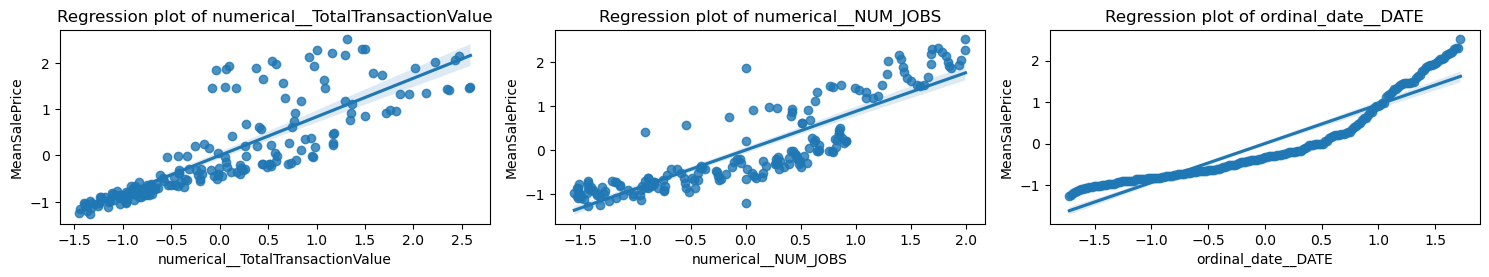

In [158]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.5)

## Perform unsupervised feature selection

Optimal number of features: 6


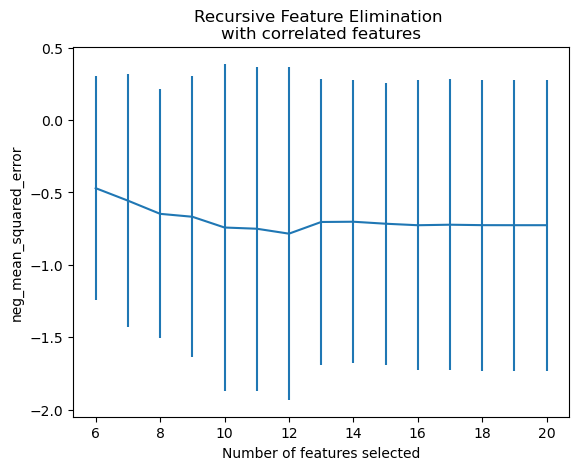

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,selected,ranking,feature_name
0,-2.501250,3.060793,-3.118218,-0.049776,-0.183579,-0.940031,-8.214645,False,2,SalesCount
1,-3.327394,3.530474,-4.838119,-0.073950,-0.182856,-2.054620,-9.487424,False,3,TotalTransactionValue
2,-3.355353,3.561451,-4.768350,-0.070855,-0.182599,-2.146089,-9.608872,False,7,MarketTempIdx
3,-2.245900,4.217169,-0.225501,-0.081070,-0.092235,-0.151081,-10.679614,False,13,DaysToClose
4,-2.468596,4.776380,-0.097918,-0.047127,-0.094898,-0.081751,-12.021288,False,4,DaysOnZillow


In [159]:
# Try recursive feature elimination to find the optimal number of features for a linear regression model
regressor = LinearRegression()
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)
rfecv_results_df.head()

In [160]:
rfe_lr_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE LR Selected Features: {rfe_lr_selected_features}")

RFE LR Selected Features: ['PctSoldAboveList' 'PctSoldBelowList' 'MORTGAGE15US' 'MORTGAGE30US'
 'RATE_DIFFERENCE' 'DATE']


Optimal number of features: 3


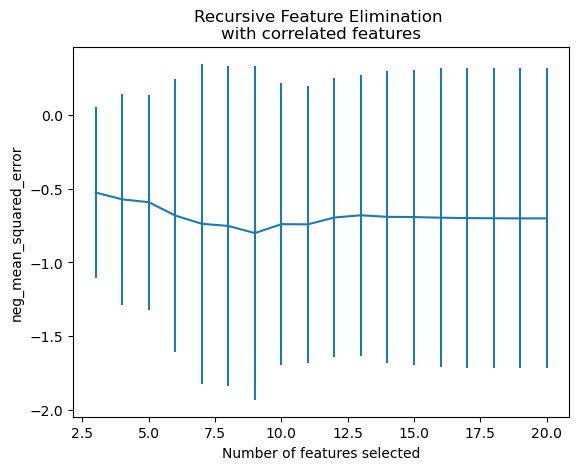

In [183]:
# Try recursive feature elimination to find the optimal number of features for a RidgeCV model
regressor = RidgeCV(alphas=np.logspace(-6, 6, num=6))
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)


In [184]:
rfe_ridge_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE Ridge Selected features: {rfe_ridge_selected_features}")

RFE Ridge Selected features: ['SalesCount' 'TotalTransactionValue' 'DATE']


In [203]:
# Try using forward SFS (SequentialFeatureSelector) to select the top 10 features
sfs_ridge_selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(n_features=6)
print(f"SFS Ridge Selected Features: {sfs_ridge_selected_features}")


RidgeCV best alpha 1.0
Selected 6 features by forward sequential featureselection in 0.862 seconds
SFS Ridge Selected Features: ['SalesCount', 'TotalTransactionValue', 'NewConstructSalesCount', 'MORTGAGE15US', 'DATE', 'CityName']


In [204]:
# Remove colinear features from the list of selected features
# sfs_ridge_selected_features = [sfs_ridge_selected_features]
sfs_ridge_selected_features = sfs_ridge_selected_features[:-2]
sfs_ridge_selected_features

['SalesCount',
 'TotalTransactionValue',
 'NewConstructSalesCount',
 'MORTGAGE15US']

In [205]:
# Update EDA object with selected features from RFE
eda.selected_feature_list = sfs_ridge_selected_features

# Now get the list of selected ordinal columns
# final_ordinal_cols = eda.get_final_ordinal_col_names(sfs_ridge_selected_features)
# len(final_ordinal_cols), final_ordinal_cols

## Perform final EDA with selected features and ordinal columns

In [206]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=['SalesCount',
                                                                                                     'TotalTransactionValue',
                                                                                                     'NewConstructSalesCount',
                                                                                                     'MORTGAGE15US'])),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['SalesCoun...
                                                                              '2009-11-30',
                                                                              '2011-02-28',
                                                                              '2008-12-31',
                                                                              '2010-03-31',
                                                                              '2012-04-30',
                                                                              '2009-06-30',
                                                                              '2011-04-30',
                                                                              '2008-11-30',
                                                                              '2011-01-31',
                                                                              '2009-10-31',
                                                                              '2010-04-30',
                                                                              '2014-03-31',
                                                                              '2013-02-28',
                                                                              '2011-05-31',
                                                                              '2010-12-31',
                                                                              '2011-12-31',
                                                                              '2008-10-31',
                                                                              '2009-09-30', ...]],
                                                                 encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['DATE'])])

In [207]:
eda.selected_feature_list

['SalesCount',
 'TotalTransactionValue',
 'NewConstructSalesCount',
 'MORTGAGE15US']

In [208]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df()
feature_analysis_df.head()

Best RidgeCV alpha: 0.01 (R^2 score:  0.96)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_date__DATE,0.939592,0.673076,0.288421,5.739266,0.559651,0.174940,2.347259
numerical__TotalTransactionValue,0.835566,0.456893,0.577406,9.623000,0.610182,0.040229,1.942870
numerical__SalesCount,0.434649,0.284848,0.578205,3.757576,0.543267,0.249849,1.512613
numerical__MORTGAGE15US,0.310723,0.128045,0.695679,1.533003,0.079723,0.720799,1.239291
numerical__NewConstructSalesCount,0.326352,0.103110,0.719779,1.182311,0.113901,0.621129,1.164492


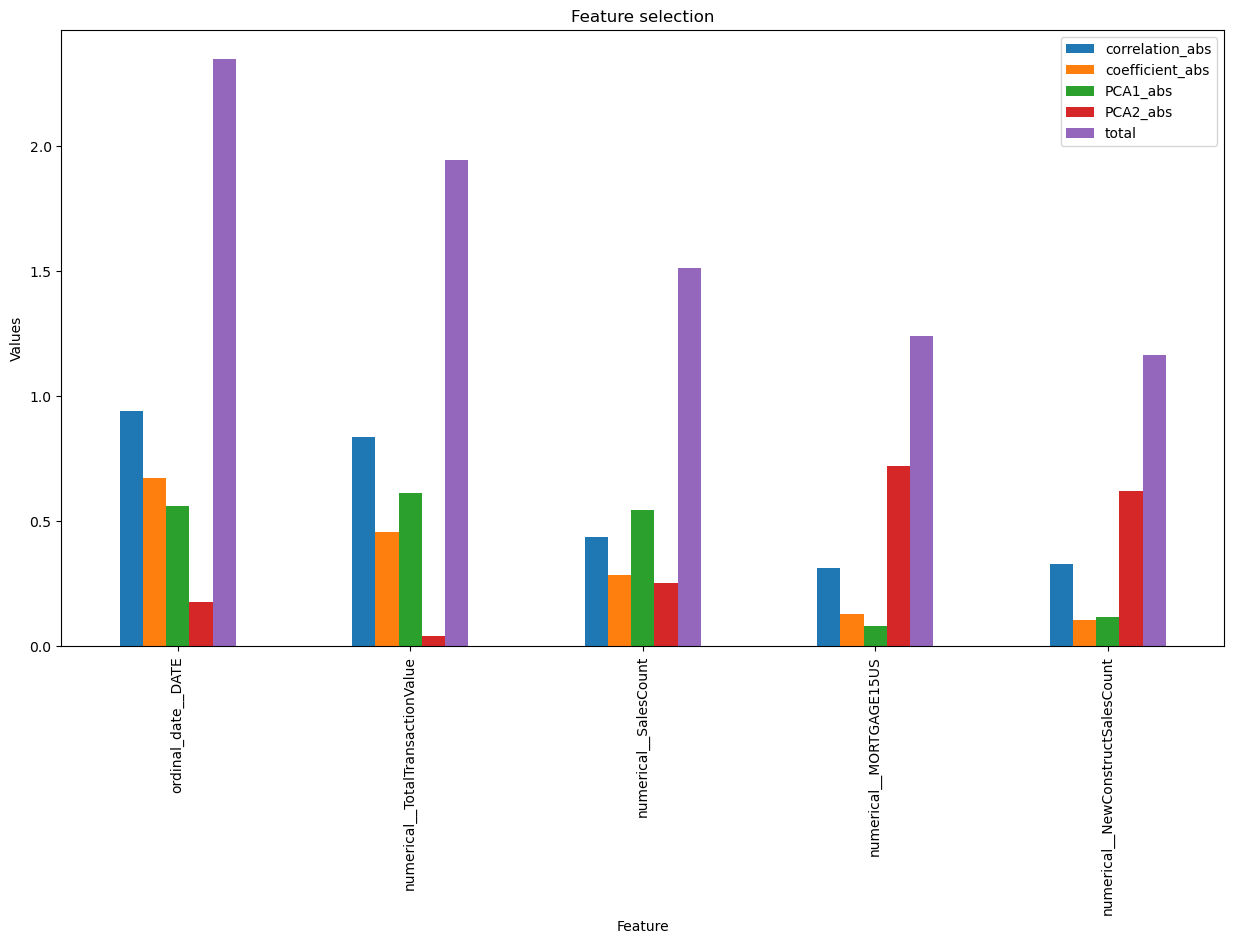

In [209]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [210]:
# Reload the data just to be safe
train_full_df = pd.read_csv(indi_file_path)

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column=target_col)
reg.set_column_transformer_properties(selected_feature_list=eda.selected_feature_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [211]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}

In [212]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 25
Number scaled X cols: 5


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time,y_pred
model_name,,,,,,,,
HistGradientBoost,0.996276,0.006126,0.993287,0.992270,0.90559,0.074595,1.554570,"[0.32459138094196316, -0.9250598363323254, 0.7..."
Ridge Regression,0.965532,0.041079,0.954981,0.948160,0.90559,0.074595,0.012027,"[0.3659345129264534, -0.8272341947863348, 0.45..."
ElasticNetCV,0.965571,0.041207,0.954842,0.947999,0.90559,0.074595,0.122241,"[0.3685697829482719, -0.8328894731634874, 0.45..."
LassoCV,0.965569,0.041239,0.954807,0.947960,0.90559,0.074595,0.063741,"[0.36942977758048184, -0.8339406705794217, 0.4..."
RidgeCV,0.965592,0.041245,0.954801,0.947952,0.90559,0.074595,0.030347,"[0.36737313410738964, -0.834991570395154, 0.45..."
Linear Regression,0.965592,0.041247,0.954798,0.947949,0.90559,0.074595,0.010785,"[0.3673875744950654, -0.835070710771473, 0.455..."


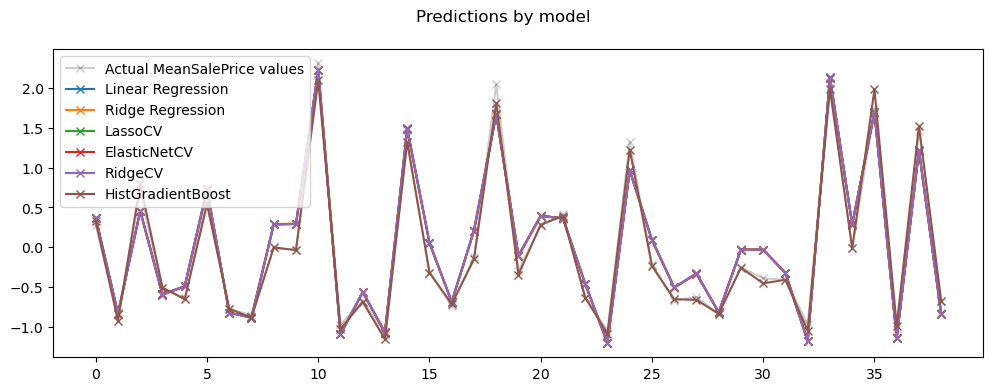

In [213]:
reg.plot_model_evaluations()

* Looks overfit to me

In [214]:
# Get the best model
reg.best_model_name

'HistGradientBoost'

## Now use the best model to predict on the test data

In [215]:
# Load test data from a different city
combined_file_path = '../../Data/Clean/combined/all_cities_combined.csv'
test_full_df = pd.read_csv(combined_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [216]:
# Drop target column
combined_file_df = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col]) 
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [217]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([150007.78146037, 152059.29711898, 159690.32741897, ...,
       303695.90132305, 309554.96159361, 309388.43183463])

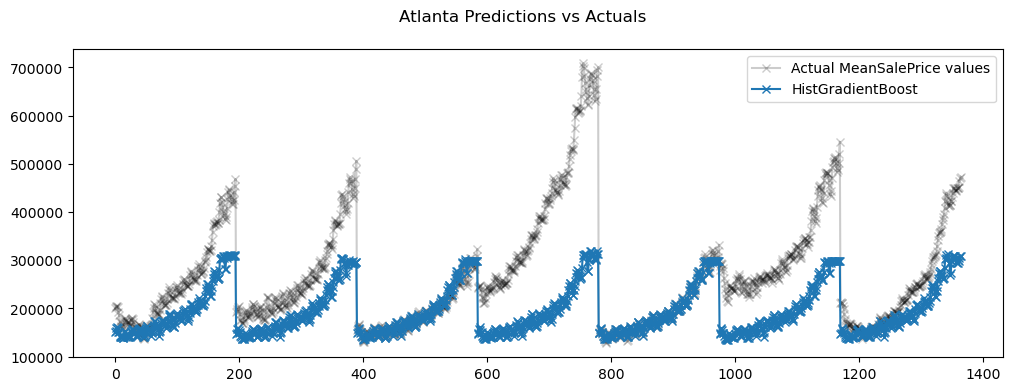

In [220]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    combined_file_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()